In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)

In [6]:
from sklearn.model_selection import train_test_split, KFold

In [7]:
n_splits = 10


In [8]:
from common import compute_rmse

In [9]:
np.arange(0.1, 1.0, 0.1)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [12]:
pred = {}
sd = {}
out = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'
for random_seed in range(10):
    pred[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print(random_seed,"\n")
    for train_percentage in range(10, 110, 10):
        print train_percentage, "\n"
        for train_max, test in kf.split(df):

            num_train = int((train_percentage*len(train_max)/100)+0.5)
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
            train_ix = df.index[train]
            test_ix = df.index[test]
           
            num_test = len(test_ix)
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = df.ix[train_test_ix], dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)
            tensor_copy = tensor.copy()
            # First n
            tensor_copy[:num_test, 1:, :] = np.NaN
            H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


(0, '\n')
10 

20 

30 

40 

50 

60 

70 

80 

90 

100 

(1, '\n')
10 

20 

30 

40 

50 

60 

70 

80 

90 

100 

(2, '\n')
10 

20 

30 

40 

50 

60 

70 

80 

90 

100 

(3, '\n')
10 

20 

30 

40 

50 

60 

70 

80 

90 

100 

(4, '\n')
10 

20 

30 

40 

50 

60 

70 

80 

90 

100 

(5, '\n')
10 

20 

30 

40 

50 

60 

70 

80 

90 

100 

(6, '\n')
10 

20 

30 

40 

50 

60 

70 

80 

90 

100 

(7, '\n')
10 

20 

30 

40 

50 

60 

70 

80 

90 

100 

(8, '\n')
10 

20 

30 

40 

50 

60 

70 

80 

90 

100 

(9, '\n')
10 

20 

30 

40 

50 

60 

70 

80 

90 

100 



In [14]:
from common import compute_rmse_fraction

In [15]:
len(compute_rmse_fraction('hvac',s[range(4, 10)],'SanDiego')[0])

181

In [16]:
len(compute_rmse('hvac',s[range(4, 10)],'SanDiego')[0])

181

In [19]:
out = {}
for random_seed in range(10):
    out[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out[random_seed][appliance] = {}
        for f in range(10, 110, 10):
            s = pd.concat(pred[random_seed][appliance][f]).ix[df.index]
            if appliance=="hvac":
                    out[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

    

In [20]:
means_df = pd.Panel(out).mean(axis=0)
means_df

,dw,fridge,hvac,mw,oven,wm
10,2.354802,9.239410,19.543947,2.082503,2.764263,2.849736
20,2.078738,8.555117,18.471469,2.070541,2.518863,1.465153
30,2.003809,7.826642,20.815454,1.904710,2.289867,1.018258
40,1.967510,7.528686,19.450646,1.886208,2.144160,0.805956
50,1.933311,7.496887,19.382984,1.840827,2.162331,0.749503
60,1.928920,7.662647,21.633918,1.828358,2.089062,0.724983
70,1.935671,7.219609,17.842409,1.780168,2.167769,0.712708
80,1.911552,7.022751,17.144706,1.775979,2.071630,0.700201
90,1.895642,7.066648,16.874688,1.754489,2.131852,0.705021
100,1.882632,7.051506,16.226711,1.759001,2.076530,0.673275


In [21]:
std_df = pd.Panel(out).std(axis=0)
std_df

,dw,fridge,hvac,mw,oven,wm
10,0.396760,0.929459,3.282532,1.761467e-01,0.449079,1.430357e+00
20,0.148039,1.094881,4.474935,2.975652e-01,0.405060,7.766940e-01
30,0.102172,1.028349,7.580053,1.977279e-01,0.230812,3.145338e-01
40,0.137084,0.560095,4.601759,1.092861e-01,0.102572,1.365624e-01
50,0.110684,0.582683,3.005059,6.723339e-02,0.093916,5.808487e-02
60,0.042238,0.805094,9.035794,6.091625e-02,0.036398,6.343019e-02
70,0.051208,0.456441,1.209041,3.840878e-02,0.073434,4.163541e-02
80,0.031145,0.254067,0.614541,2.944866e-02,0.015105,3.959475e-02
90,0.016891,0.105567,0.337145,2.341393e-02,0.033281,2.902259e-02
100,0.000000,0.000000,0.000000,2.340556e-16,0.000000,1.170278e-16


array([<matplotlib.axes._subplots.AxesSubplot object at 0x113c6b410>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11408de50>], dtype=object)

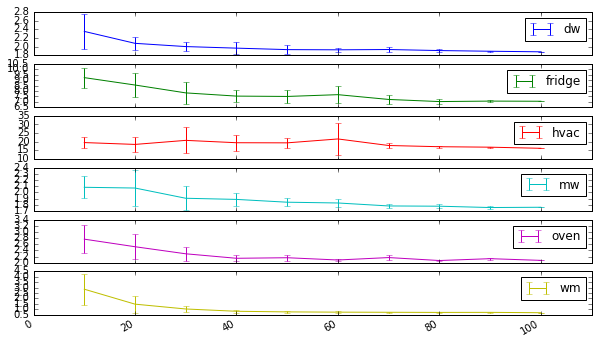

In [26]:
means_df.plot(subplots=True, yerr=std_df, figsize=(10, 6), xlim=(0, 110))